# Synthetic dataset

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib.colors import ListedColormap
from matplotlib.patches import Patch
from scipy.stats import beta
from sklearn.model_selection import train_test_split
import shap
from GeoConformalizedExplainer import GeoConformalizedExplainer

/opt/anaconda3/envs/UncertaintyGeoXAI/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


## Plot Functions

In [2]:
plt.rcParams['legend.fontsize'] = 16


def plot_s(b, k=3, size=50, title=None, sub_titles=None, non_spatial=None, vmin=None, vmax=None, interpolation=None,
           cmap=plt.get_cmap('viridis', 36)):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)

    for i in range(k):
        ax = axes[i]
        if i in non_spatial:
            ax.scatter(b[i][0], b[i][1], s=5, color='black')
            ax.set_ylim(b[i][2], b[i][3])
            ax.set_xlim(-2.5, 2.5)
            ax.set_xlabel(r'$X_{}$'.format(i), fontsize=16)
            ax.xaxis.set_tick_params(labelsize=20)
            ax.yaxis.set_tick_params(labelsize=20)
            ax.grid(False)
        else:
            if vmin is None:
                v_min = np.floor(b[i].min() * 10) / 10
            else: v_min = vmin
            if vmax is None:
                v_max = np.ceil(b[i].max() * 10) / 10
            else:
                v_max = vmax
            c = ax.imshow(b[i].reshape(size, size), cmap=cmap, vmin=v_min, vmax=v_max, interpolation=interpolation)
            cb = fig.colorbar(c, ax=ax)
            cb.ax.tick_params(labelsize=20)
            ax.set_xticks(np.arange(-0.5, size, 5))
            ax.set_yticks(np.arange(-0.5, size, 5))
            ax.set_xticklabels([])
            ax.set_yticklabels([])
            ax.set_axis_off()
            ax.tick_params(axis='x', colors=(0, 0, 0, 0))
            ax.tick_params(axis='y', colors=(0, 0, 0, 0))
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.pdf', bbox_inches='tight')

In [3]:
def plot_uncertainty(u, k=3, title=None, sub_titles=None, cmap='flare', s_limits=(5, 20), hue='geo_uncertainty',
                     size='shap_abs'):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)
    sns.set_style("white")

    for i in range(k):
        ax = axes[i]
        data = u[i]
        g = sns.scatterplot(data=data, x='x', y='y', hue=hue, size=size, palette=cmap, sizes=s_limits, legend=False,
                            edgecolor='.7', ax=ax)
        g.set(xlabel='', ylabel='', aspect='equal')
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)

    plt.savefig(f'{title}.pdf', bbox_inches='tight')


In [4]:
def plot_coverage(c, k=3, size=50, title=None, sub_titles=None, colors=None, cmap=None):
    fig, axes = plt.subplots(1, k, figsize=(6 * k, 5), dpi=500)
    legend_elements = [Patch(facecolor=colors[0], edgecolor='.7', label='Not Covered'),
                       Patch(facecolor=colors[1], edgecolor='.7', label='Covered')]
    for i in range(k):
        ax = axes[i]
        ax.imshow(c[i].reshape(size, size), cmap=cmap, vmin=0, vmax=1)
        ax.legend(handles=legend_elements, loc='upper right', title='')
        ax.set_title(sub_titles[i], fontsize=20, y=1.05)
    plt.savefig(f'{title}.pdf', bbox_inches='tight')


## Uncertainty Generation

In [5]:
from scipy.stats import multivariate_normal

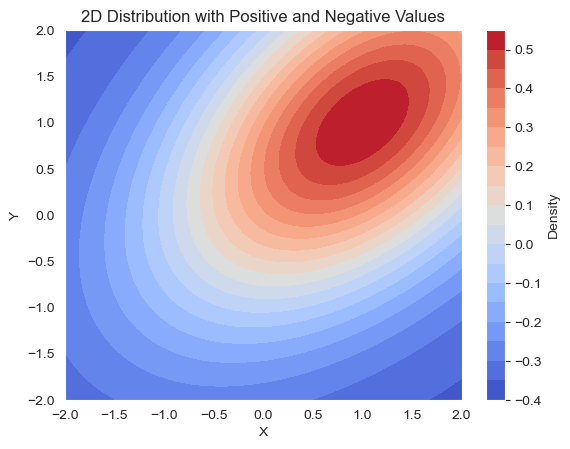

In [6]:
x = np.linspace(-2, 2, 50)
y = np.linspace(-2, 2, 50)
X, Y = np.meshgrid(x, y)
pos = np.dstack((X, Y))
mean = [1, 1]
covariance = [[2, 1], [1, 2]]
rv = multivariate_normal(mean, covariance)
n1 = rv.pdf(pos) * 10
n1 = n1 - n1.mean()

# Plot the distribution
plt.contourf(X, Y, n1, levels=20, cmap='coolwarm')
plt.colorbar(label='Density')
plt.title('2D Distribution with Positive and Negative Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

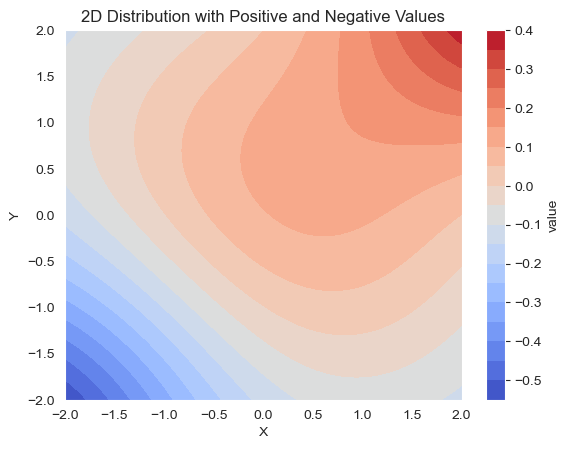

In [7]:
gaussians = [
    multivariate_normal([3, 3], [[2, 0], [0, 2]]).pdf(pos),
    multivariate_normal([-3, -3], [[3, 1], [1, 3]]).pdf(pos),
    multivariate_normal([0, 0], [[4, 0], [0, 4]]).pdf(pos)
]

n2 = (gaussians[0] - gaussians[1] + gaussians[2]) * 10
n2 = n2 - n2.mean()

# Plot the distribution
plt.contourf(X, Y, n2, levels=20, cmap='coolwarm')
plt.colorbar(label='value')
plt.title('2D Distribution with Positive and Negative Values')
plt.xlabel('X')
plt.ylabel('Y')
plt.show()

## Data generation

In [11]:
size = 50

b1 = np.ones((size, size))
b2 = np.ones((size, size))

for i in range(size):
    for j in range(size):
        b1[i, j] = (i + j) / 49 * 3
        b2[i, j] = 3 * (np.sin(-2 + 4 / 49 * i) * np.cos(-2 + 4 / 49 * j) + 1)


In [12]:
b1 = b1.reshape(-1)
b2 = b2.reshape(-1)
n1_ = n1.reshape(-1)
n2_ = n2.reshape(-1)

In [13]:
np.random.seed(222)

X1 = np.random.uniform(-2, 2, size * size)
X2 = np.random.uniform(-2, 2, size * size)
X3 = np.random.uniform(-2, 2, size * size)
X4 = np.random.uniform(-2, 2, size * size)

X = np.vstack([X1, X2, X3, X4]).T
u = np.array([np.linspace(0, size - 1, num=size)] * size).reshape(-1)
v = np.array([np.linspace(0, size - 1, num=size)] * size).T.reshape(-1)
coords = np.array(list(zip(u, v)))

k = X.shape[1]
n = X.shape[0]

In [14]:
X_coords = pd.DataFrame(np.concatenate((X, np.array(coords)), axis=1),
                        columns=['X1', 'X2', 'X3', 'X4', 'x_coord', 'y_coord'])

In [15]:
X_coords

X1        X2        X3        X4  x_coord  y_coord
0     0.104114  0.964917  1.011381  1.192011      0.0      0.0
1     0.741269 -0.440030 -0.936705  1.024414      1.0      0.0
2     1.342697 -0.875739 -1.148677 -1.992029      2.0      0.0
3     0.615061  1.082512 -1.266801 -0.424231      3.0      0.0
4    -1.851912  0.026923 -0.659943  1.062233      4.0      0.0
...        ...       ...       ...       ...      ...      ...
2495 -1.798074 -0.779403  0.012337 -1.363451     45.0     49.0
2496  0.239688 -0.666447  0.497581  0.348732     46.0     49.0
2497 -1.719665 -1.038000 -0.700350  1.508266     47.0     49.0
2498 -0.650496 -1.045958  0.776005  1.999300     48.0     49.0
2499  0.801800 -0.750421  0.581807  0.487717     49.0     49.0

[2500 rows x 6 columns]

In [16]:
# f0 = b0
f1 = (b1 + n1_) * X_coords.values[:, 0]
f2 = (b2 + n2_) * X_coords.values[:, 1]
f3 = X_coords.values[:, 2] ** 2
f4 = np.abs(X_coords.values[:, 3]) * 2

In [17]:
y = pd.DataFrame(f1 + f2 + f3 + f4, columns=['y'])

In [18]:
b = [b1, b2, [X_coords.values[:, 2], f3, -1, 5], [X_coords.values[:, 3], f4, -1, 6]]
# b = [b1, b2, b3, [X_coords.values[:, 3], f4, -6, 6], [X_coords.values[:, 4], f5, -1, 5]]

In [19]:
sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_4(X_4)$']
# sub_titles = [r'$\beta_1(u,v)$', r'$\beta_2(u,v)$', r'$\beta_{3}(u, v)$', r'$f_4(X_4)$', r'$f_5(X_5)$']

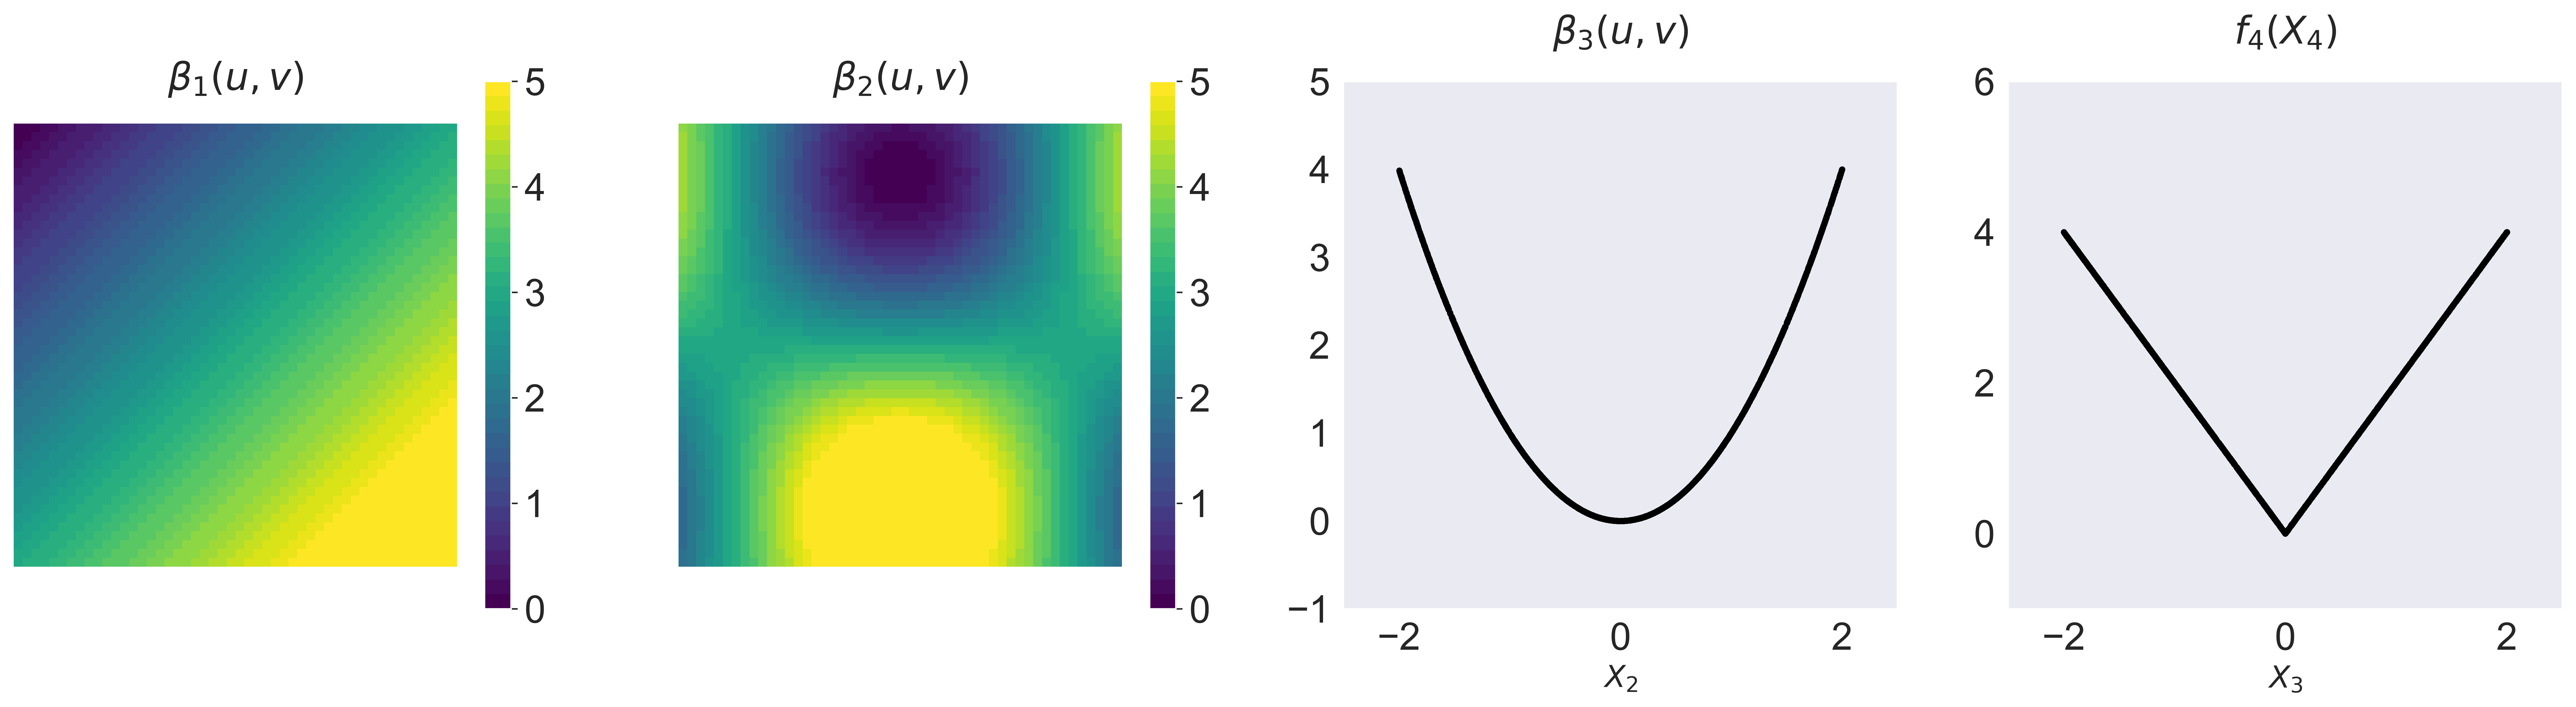

In [20]:
plot_s(b=b, k=4, sub_titles=sub_titles, vmin=0, vmax=5, title='TrueModel', non_spatial=[2, 3], size=size)

In [21]:
b_n = [b1 + n1_, b2 + n2_, n1_, n2_]

In [22]:
sub_titles_bn = [r'$\beta_1(u,v) + n_1(u,v)$', r'$\beta_2(u,v) + n_2(u,v)$', r'$n_1$',
                 r'$n_2$']

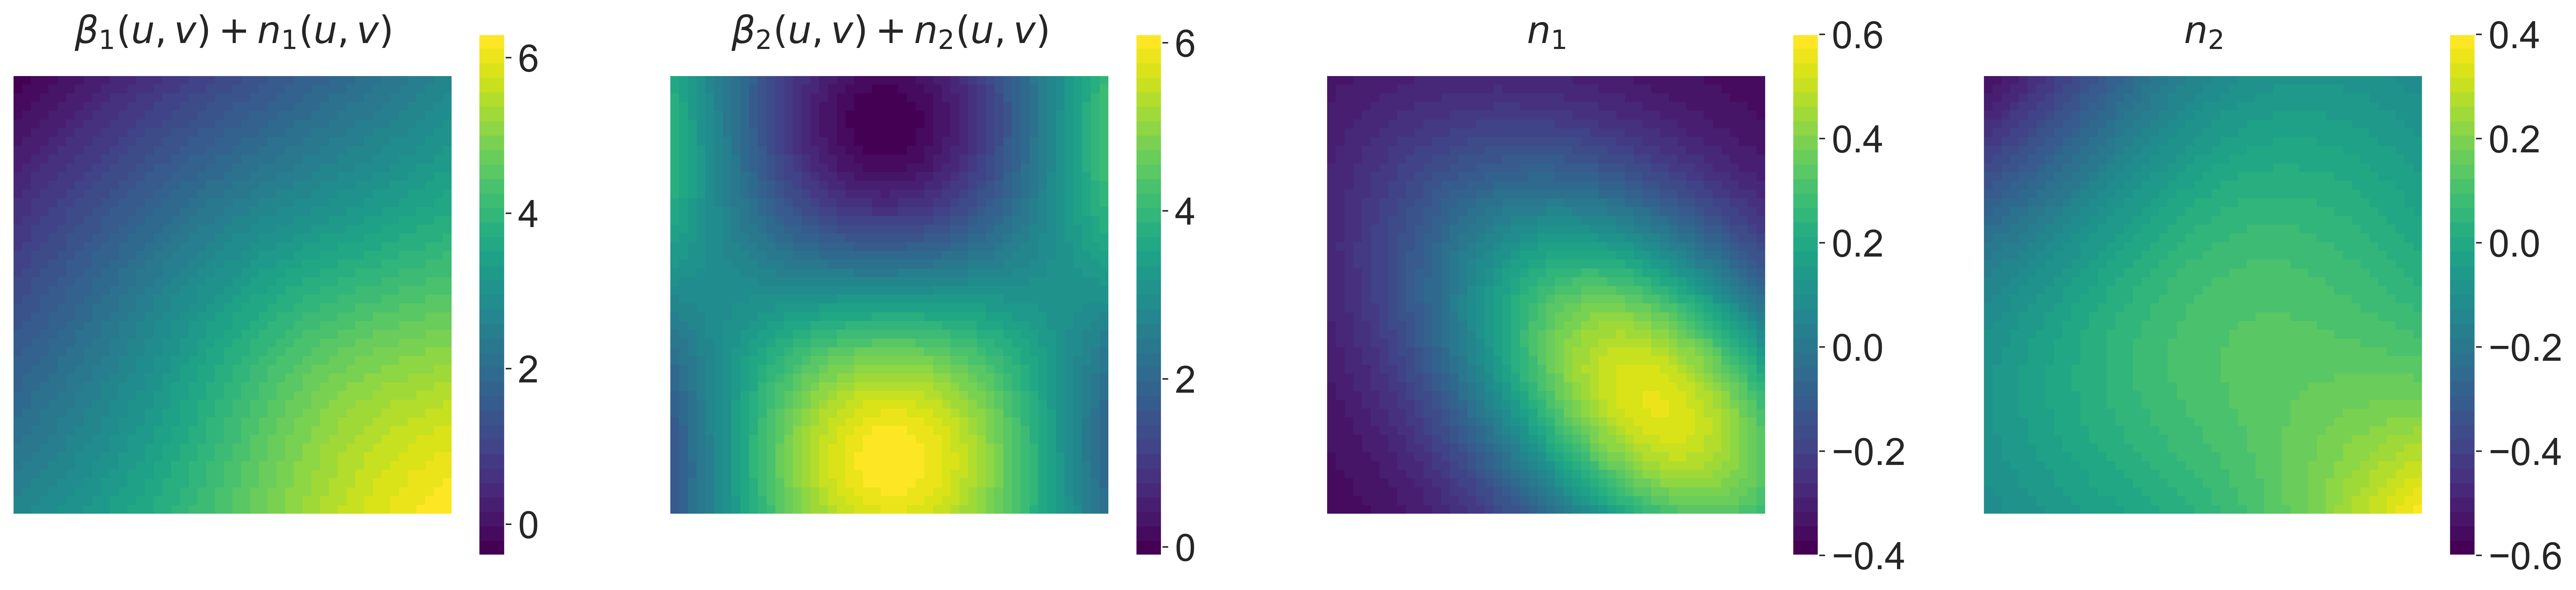

In [23]:
plot_s(b=b_n, k=4, sub_titles=sub_titles_bn, title='TrueModel_with_noise', non_spatial=[], size=size)

In [24]:
class Model:
    def __init__(self, f):
        self.predict = f

In [ ]:
def true_model_predict(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    u = X_coords[:, -1].astype(int)
    v = X_coords[:, -2].astype(int)
    b_1 = (u + v) / 49 * 3
    b_2 = 3 * (np.sin(-2 + 4 / 49 * u) * np.cos(-2 + 4 / 49 * v) + 1)
    f1 = b_1 * X_coords[:, 0]
    f2 = b_2 * X_coords[:, 1]
    f3 = X_coords[:, 2] ** 2
    f4 = np.abs(X_coords[:, 3]) * 2
    y_pred = f1 + f2 + f3 + f4
    return y_pred

In [25]:
def true_model_predict_with_coeff_noise(X_coords):
    try:
        X_coords = X_coords.values
    except:
        pass
    u = X_coords[:, -1].astype(int)
    v = X_coords[:, -2].astype(int)
    b_1 = (u + v) / 49 * 3
    b_2 = 3 * (np.sin(-2 + 4 / 49 * u) * np.cos(-2 + 4 / 49 * v) + 1)
    f1 = (b_1 + n1[u, v]) * X_coords[:, 0]
    f2 = (b_2 + n2[u, v]) * X_coords[:, 1]
    f3 = X_coords[:, 2] ** 2
    f4 = np.abs(X_coords[:, 3]) * 2
    y_pred = f1 + f2 + f3 + f4
    return y_pred

In [26]:
def shap_value_f(x):
    explainer_ = shap.Explainer(true_model_predict, x, algorithm='auto')
    return explainer_(x).values

In [27]:
true_model = Model(true_model_predict)

In [28]:
loc = X_coords[['x_coord', 'y_coord']]

In [29]:
X_train, X_temp, loc_train, loc_temp = train_test_split(X_coords, loc, train_size=0.8)

In [30]:
X_calib, X_test, loc_calib, loc_test = train_test_split(X_temp, loc_temp, train_size=0.5)

In [31]:
explainer = GeoConformalizedExplainer(prediction_f=true_model.predict,
                                      x_train=X_train,
                                      x_calib=X_calib,
                                      coord_calib=loc_calib.values,
                                      miscoverage_level=0.1,
                                      band_width=25,
                                      shap_value_f=shap_value_f,
                                      feature_names=X_calib.columns)

In [32]:
results = explainer.uncertainty_aware_explain(x_test=X_coords, coord_test=loc.values)

Training SHAP
Calibrating SHAP
Testing SHAP
Explaining Variables


In [33]:
results.accuracy_summary()

coverage_probability        R2      RMSE   SHAP_Var  Pred_SHAP_Var
X1                     1.0000  0.999426  0.088967  13.793320      13.774587
X2                     0.9568  0.937664  0.916767  13.482810      13.717376
X3                     0.9300  0.942365  0.285304   1.412315       1.415894
X4                     0.8264  0.976813  0.176651   1.345792       1.348034
x_coord                1.0000  0.981351  0.099936   0.535545       0.538377
y_coord                1.0000  0.946260  0.229666   0.981503       0.958637

100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00:000:00
100% (5 of 5) |##########################| Elapsed Time: 0:00:00 Time:  0:00

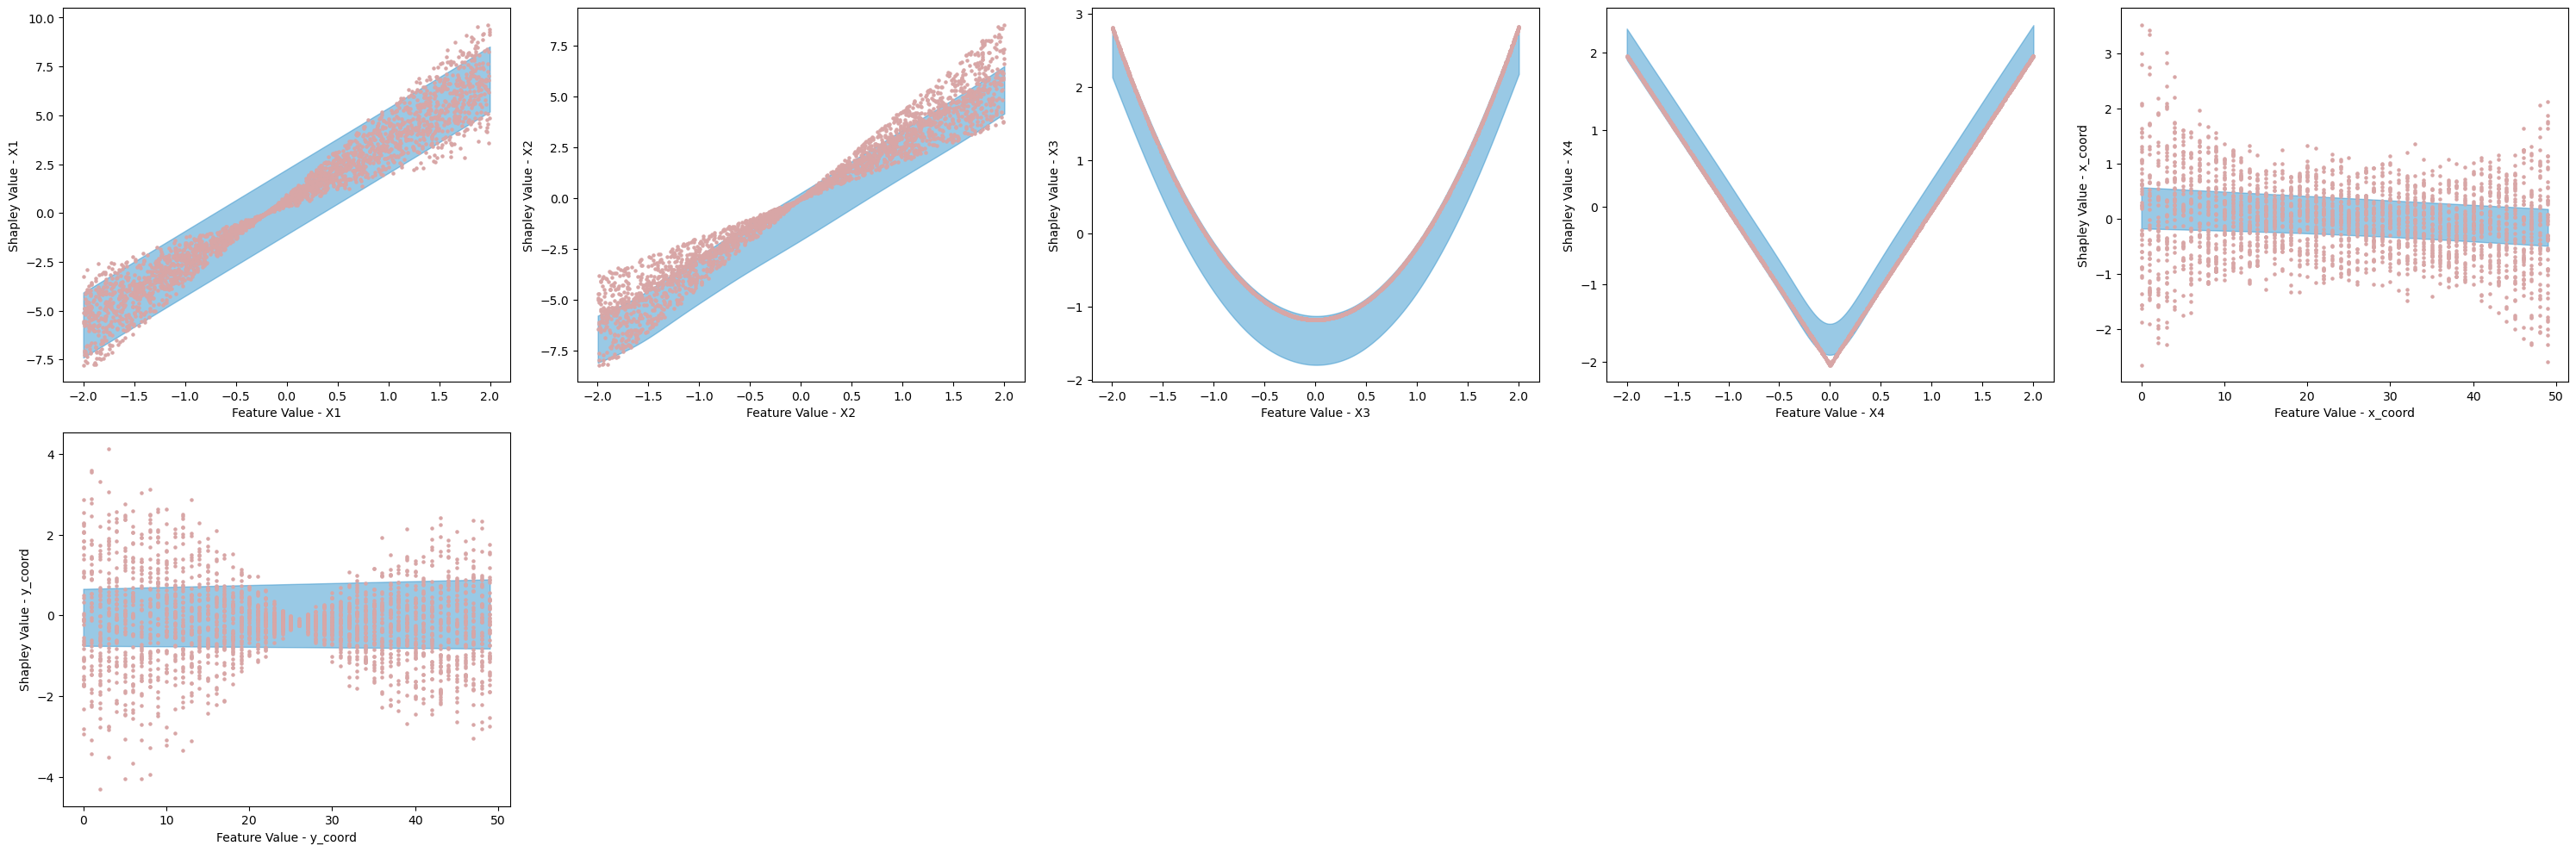

In [34]:
results.plot_partial_dependence_with_fitted_bounds()

In [35]:
pred_results = results.result_geo

In [36]:
pred_results

X1_shap   X2_shap   X3_shap   X4_shap  x_coord_shap  y_coord_shap  \
0     0.420354  2.908264 -0.152241  0.344131      0.541461      0.004148   
1     1.366100 -1.248583 -0.297716  0.008937     -0.720944     -0.643943   
2     2.300869 -2.473092  0.144326  1.944166     -1.333346     -1.120886   
3     1.236072  3.054276  0.429653 -1.191429      0.037573     -0.712215   
4    -2.606280  0.093468 -0.739607  0.084575      1.443779      1.705022   
...        ...       ...       ...       ...           ...           ...   
2495 -7.434383 -2.552782 -1.174980  0.687012     -1.175907     -1.718472   
2496  2.069815 -2.133938 -0.927545 -1.342427      0.268947     -0.177498   
2497 -7.141326 -3.247948 -0.684641  0.976641     -0.964310     -1.591186   
2498 -2.118994 -3.198529 -0.572948  1.958710     -0.099539     -0.747937   
2499  4.770369 -2.243281 -0.836633 -1.064457      0.910031      0.364326   

      X1_value  X2_value  X3_value  X4_value  ...  y_coord_geo_uncertainty  \
0     0.104114  0.964917  1.011381  1.192011  ...                 0.712326   
1     0.741269 -0.440030 -0.936705  1.024414  ...                 0.717537   
2     1.342697 -0.875739 -1.148677 -1.992029  ...                 0.717537   
3     0.615061  1.082512 -1.266801 -0.424231  ...                 0.717537   
4    -1.851912  0.026923 -0.659943  1.062233  ...                 0.717537   
...        ...       ...       ...       ...  ...                      ...   
2495 -1.798074 -0.779403  0.012337 -1.363451  ...                 0.872382   
2496  0.239688 -0.666447  0.497581  0.348732  ...                 0.872382   
2497 -1.719665 -1.038000 -0.700350  1.508266  ...                 0.872382   
2498 -0.650496 -1.045958  0.776005  1.999300  ...                 0.872382   
2499  0.801800 -0.750421  0.581807  0.487717  ...                 0.872382   

      y_coord_uncertainty  y_coord_upper_bound  y_coord_lower_bound  \
0                0.760798             0.808658            -0.615993   
1                0.760798             0.177470            -1.257603   
2                0.760798            -0.288539            -1.723612   
3                0.760798             0.116468            -1.318605   
4                0.760798             2.406649             0.971575   
...                   ...                  ...                  ...   
2495             0.760798            -0.577602            -2.322366   
2496             0.760798             0.938992            -0.805771   
2497             0.760798            -0.512796            -2.257559   
2498             0.760798             0.319374            -1.425389   
2499             0.760798             1.428740            -0.316023   

      y_coord_coverage_probability  y_coord_pred  y_coord_shap_abs     x  \
0                              1.0      0.096333          0.004148   0.0   
1                              1.0     -0.540066          0.643943   1.0   
2                              1.0     -1.006075          1.120886   2.0   
3                              1.0     -0.601068          0.712215   3.0   
4                              1.0      1.689112          1.705022   4.0   
...                            ...           ...               ...   ...   
2495                           1.0     -1.449984          1.718472  45.0   
2496                           1.0      0.066611          0.177498  46.0   
2497                           1.0     -1.385177          1.591186  47.0   
2498                           1.0     -0.553007          0.747937  48.0   
2499                           1.0      0.556359          0.364326  49.0   

         y       geometry  
0      0.0    POINT (0 0)  
1      0.0    POINT (1 0)  
2      0.0    POINT (2 0)  
3      0.0    POINT (3 0)  
4      0.0    POINT (4 0)  
...    ...            ...  
2495  49.0  POINT (45 49)  
2496  49.0  POINT (46 49)  
2497  49.0  POINT (47 49)  
2498  49.0  POINT (48 49)  
2499  49.0  POINT (49 49)  

[2500 rows x 57 columns]

In [58]:
sub_titles = [r'$\beta_1$', r'$\beta_2$', r'$\phi_3$', r'$\phi_4$']

In [59]:
pred_b = [pred_results['X1_pred'].values,
          pred_results['X2_pred'].values,
          [X_coords.values[:, 2], pred_results['X3_pred'].values, -2, 4],
          [X_coords.values[:, 3], pred_results['X4_pred'].values, -3, 3]]

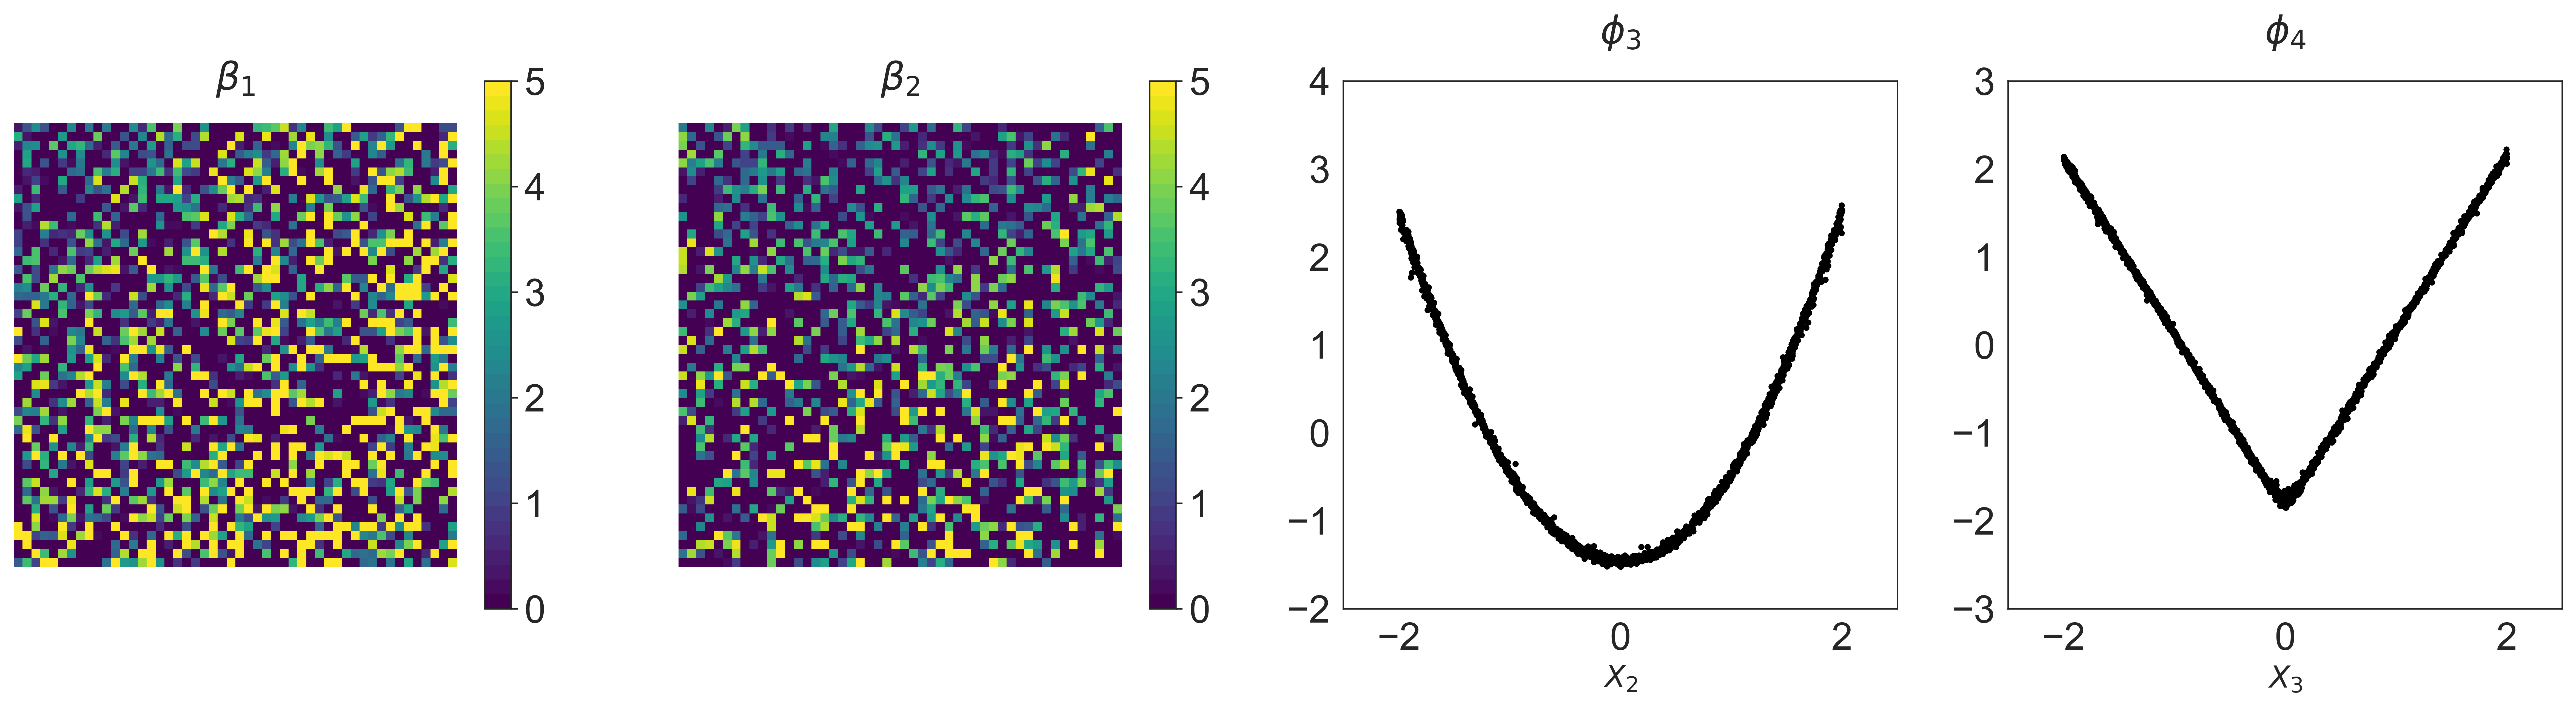

In [60]:
plot_s(pred_b, k=4, sub_titles=sub_titles, vmin=0, vmax=5, title='Synthetic data validation - ConformalSHAP + Noise',
       non_spatial=[2, 3], size=size)

In [61]:
pred_b_shap = [pred_results['X1_shap'].values,
               pred_results['X2_shap'].values,
               [X_coords.values[:, 2], pred_results['X3_shap'].values, -2, 4],
               [X_coords.values[:, 3], pred_results['X4_shap'].values, -3, 3]]

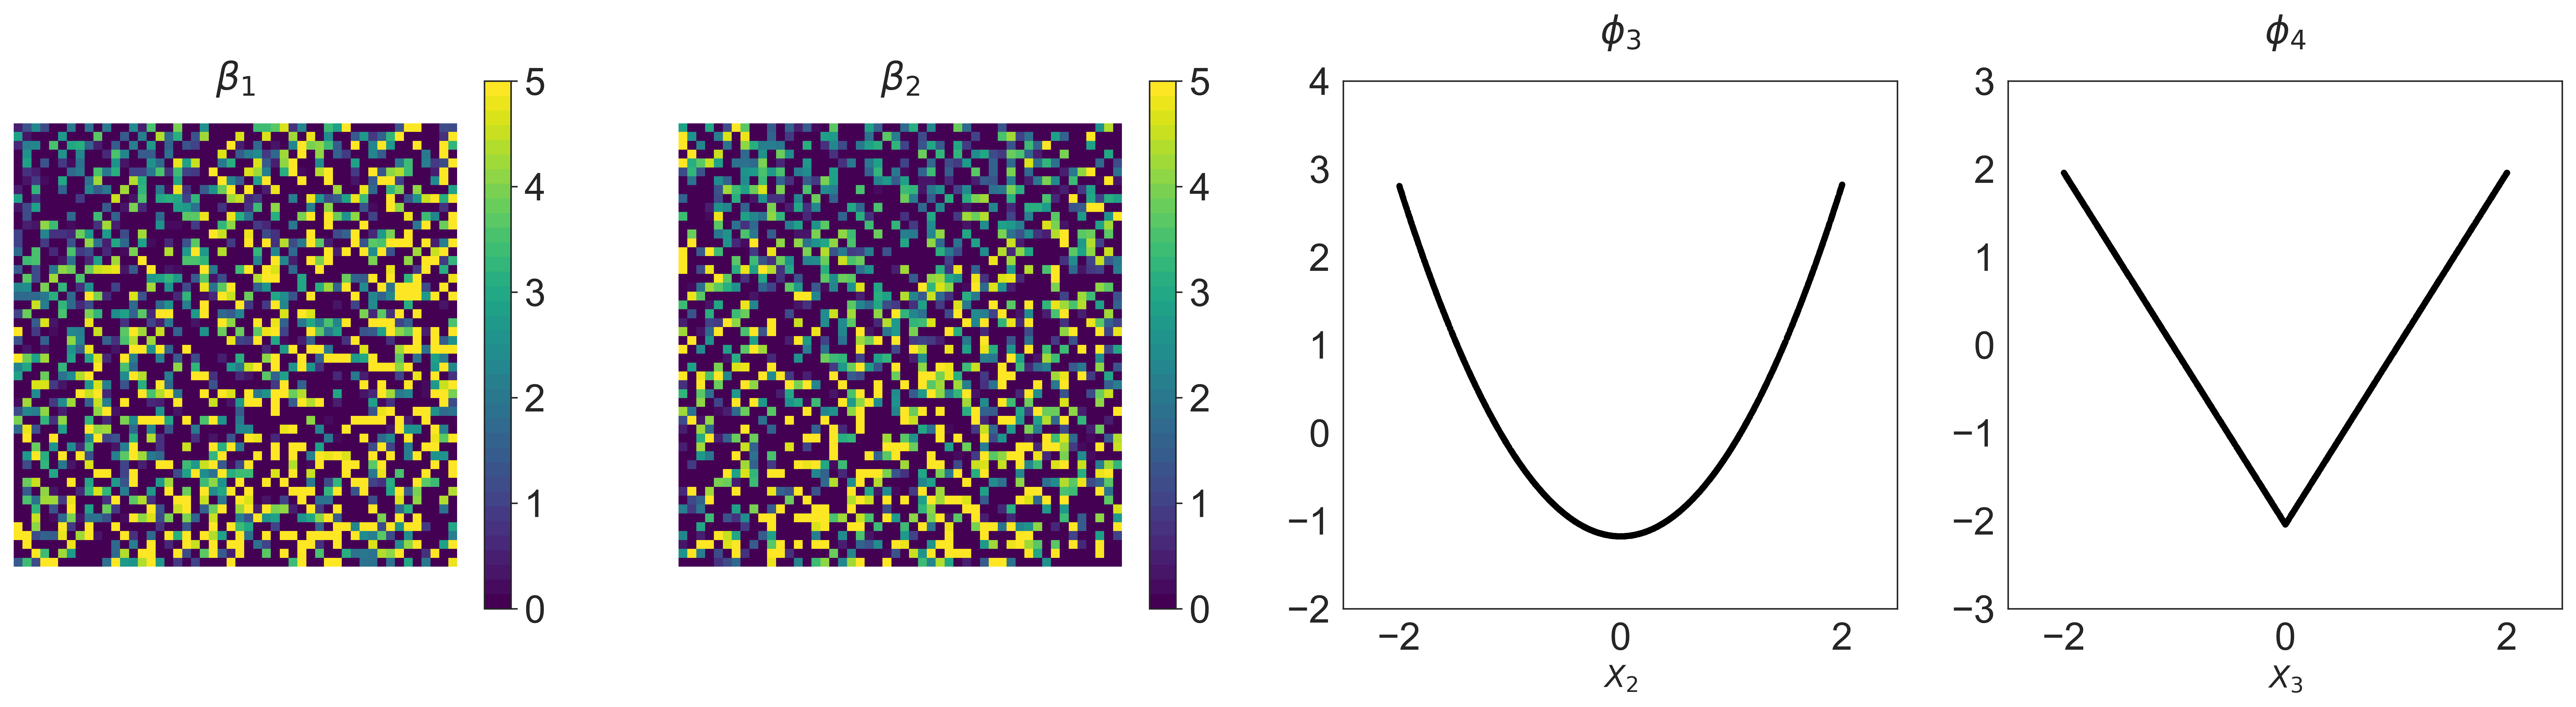

In [62]:
plot_s(pred_b_shap, k=4, sub_titles=sub_titles, vmin=0, vmax=5, title='Synthetic data validation + Noise',
       non_spatial=[2, 3], size=size)

In [42]:
shap_pred_gwr = results.get_svc(cols=[0, 1], coef_type='gwr', bw_max=10)

In [63]:
pred_b_ = [shap_pred_gwr[:, 0],
           shap_pred_gwr[:, 1],
           [X_coords.values[:, 2], pred_results['X3_pred'].values, -2, 4],
           [X_coords.values[:, 3], pred_results['X4_pred'].values, -3, 3]]

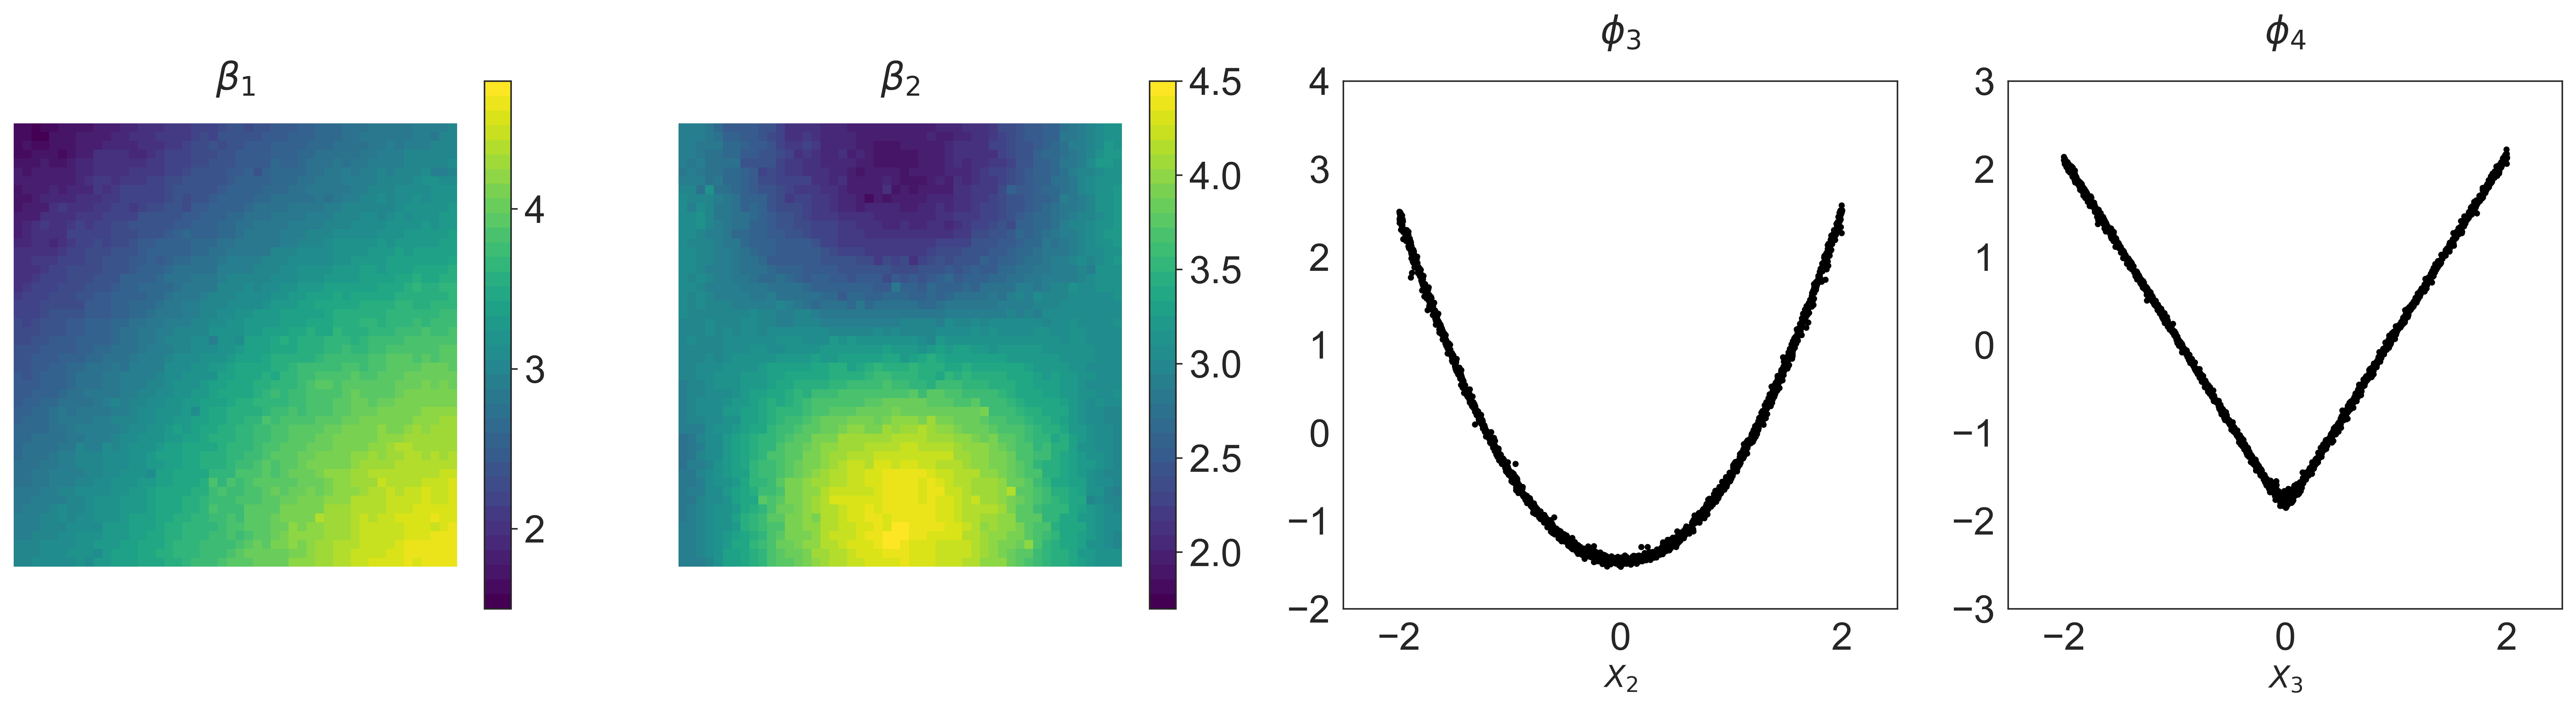

In [64]:
plot_s(pred_b_, k=4, sub_titles=sub_titles, title='Synthetic data validation - ConformalSHAPSmoothed + Noise',
       non_spatial=[2, 3], size=size)

In [45]:
X1_cover = (pred_results['X1_shap'] <= pred_results['X1_upper_bound']) & (
            pred_results['X1_shap'] >= pred_results['X1_lower_bound'])

In [46]:
X2_cover = (pred_results['X2_shap'] <= pred_results['X2_upper_bound']) & (
            pred_results['X2_shap'] >= pred_results['X2_lower_bound'])

In [47]:
b_cover = [X1_cover.values, X2_cover.values]

In [48]:
sub_titles = [r'$Cover_1$', r'$Cover_2$']

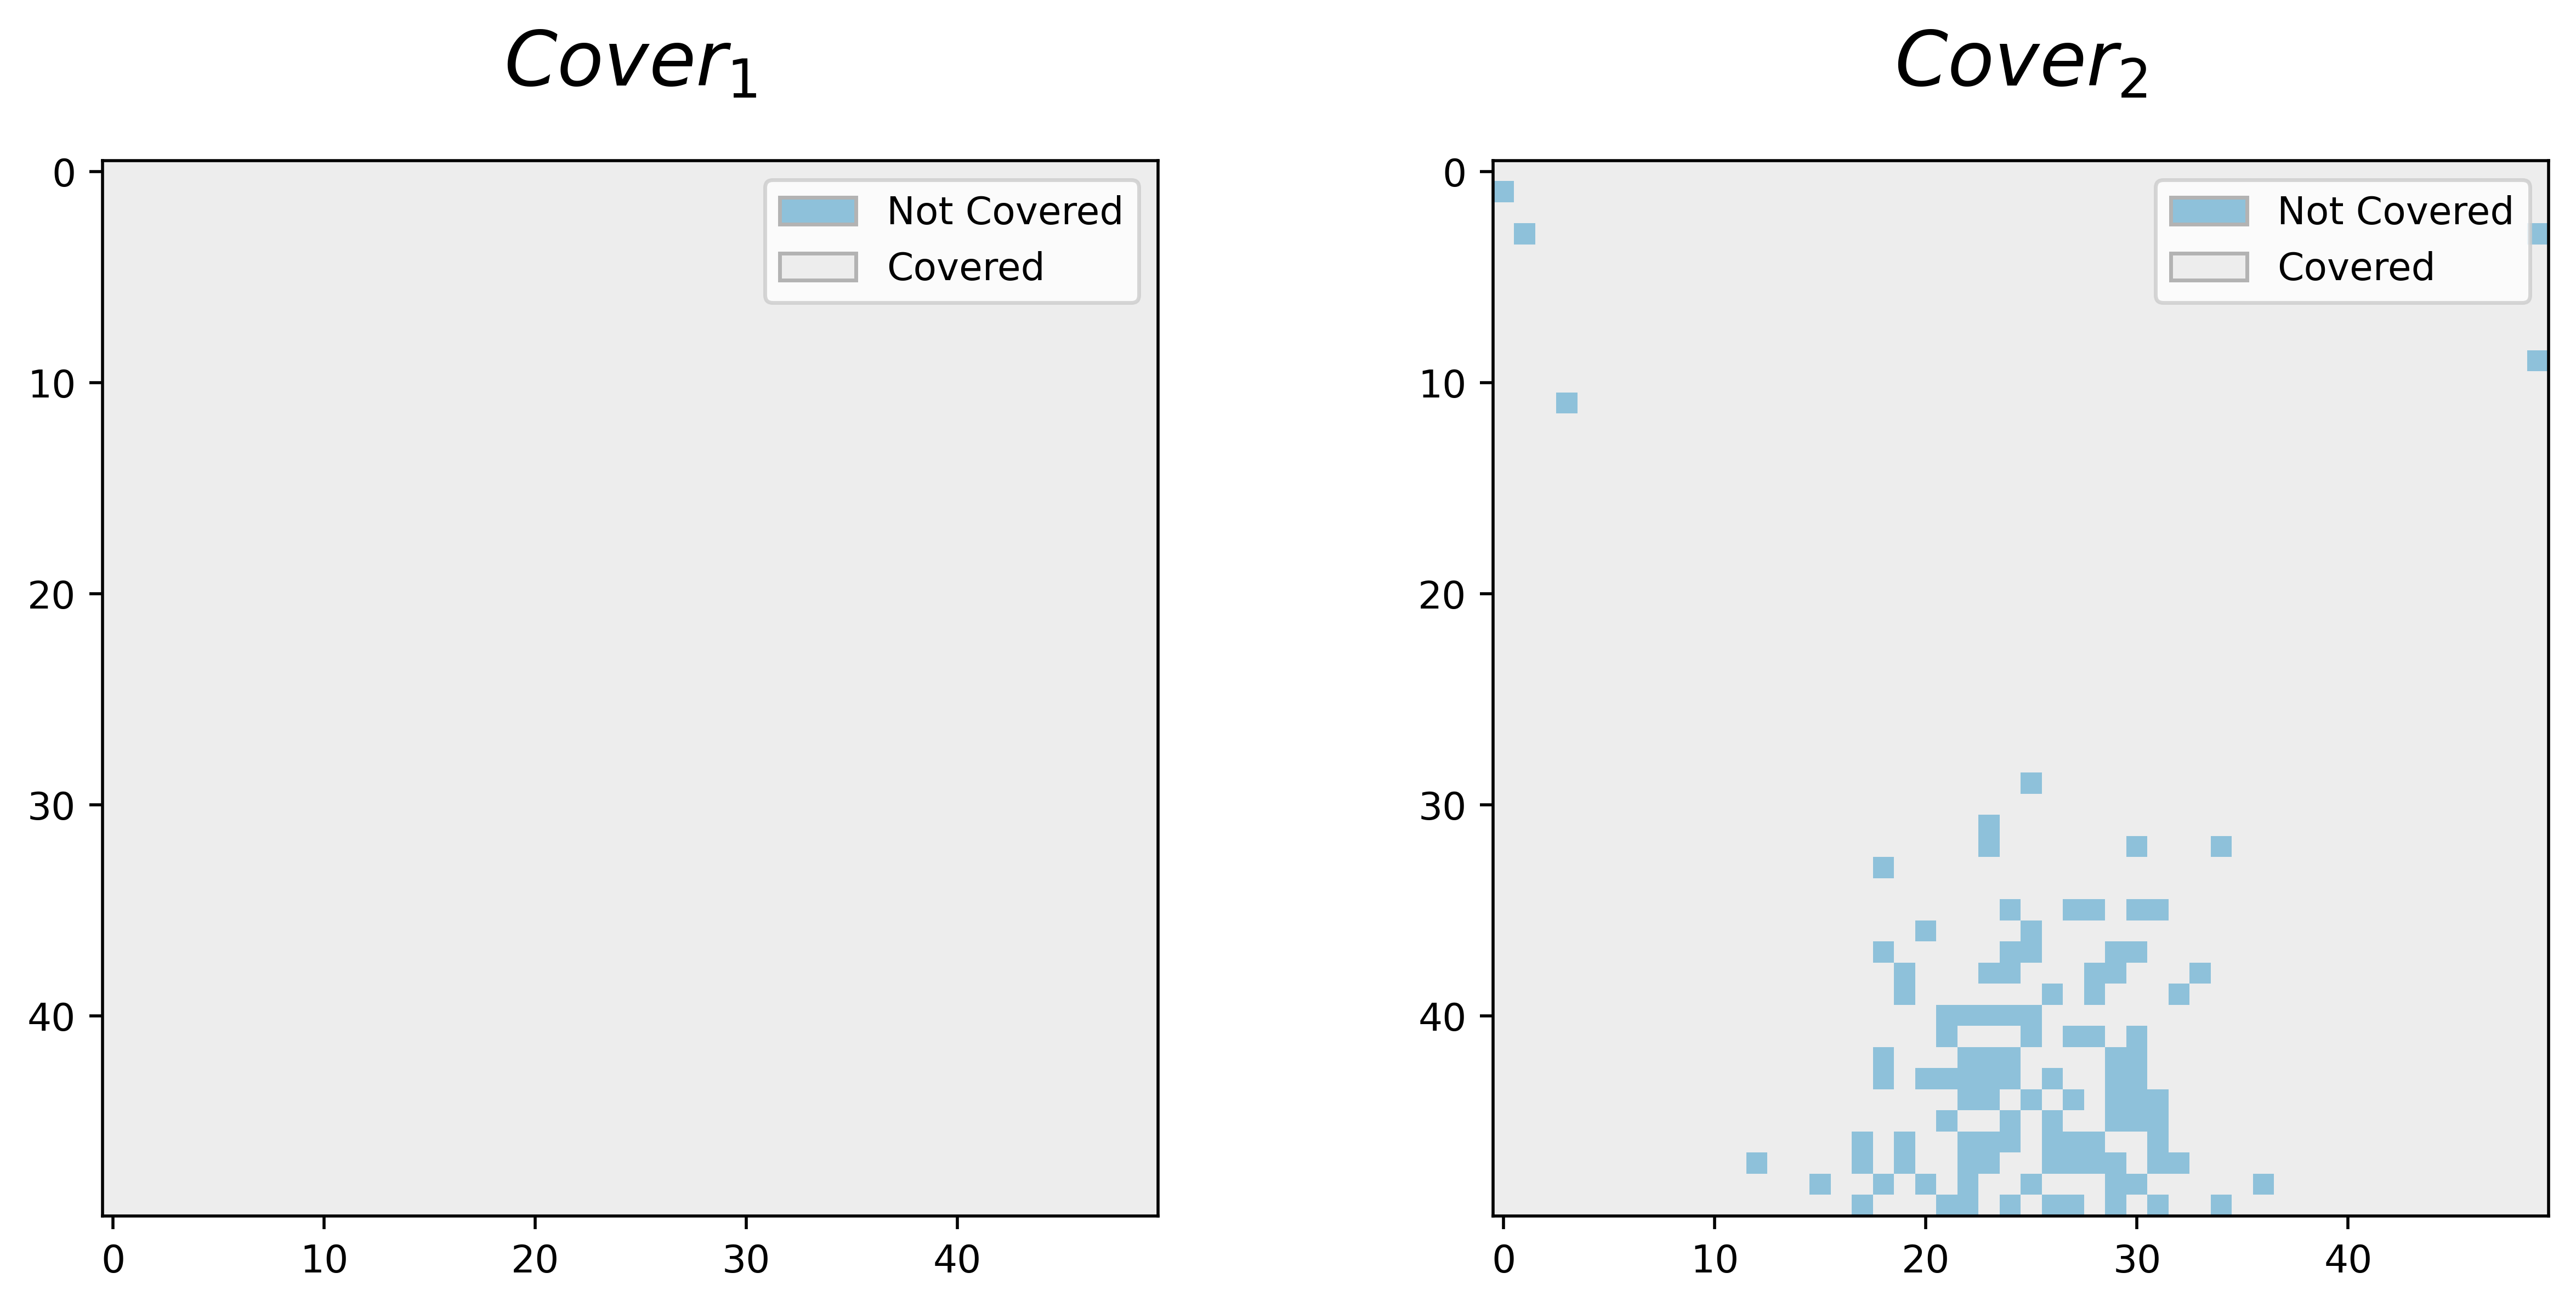

In [49]:
binary_cmap = ListedColormap(['#8ec1da', '#ededed'])
plot_coverage(b_cover, k=2, sub_titles=[r'$Cover_1$', r'$Cover_2$'], colors=['#8ec1da', '#ededed'],
              cmap=binary_cmap, title='Coverage - ConformalSHAP + Noise')

In [50]:
X1_geo_uncertainty = pred_results['X1_geo_uncertainty'].values.reshape(-1)
X2_geo_uncertainty = pred_results['X2_geo_uncertainty'].values.reshape(-1)

geo_uncertainty_list = [X1_geo_uncertainty, X2_geo_uncertainty]
sub_titles_uncertainty = [r'$U_1(u,v)$', r'$U_2(u,v)$']

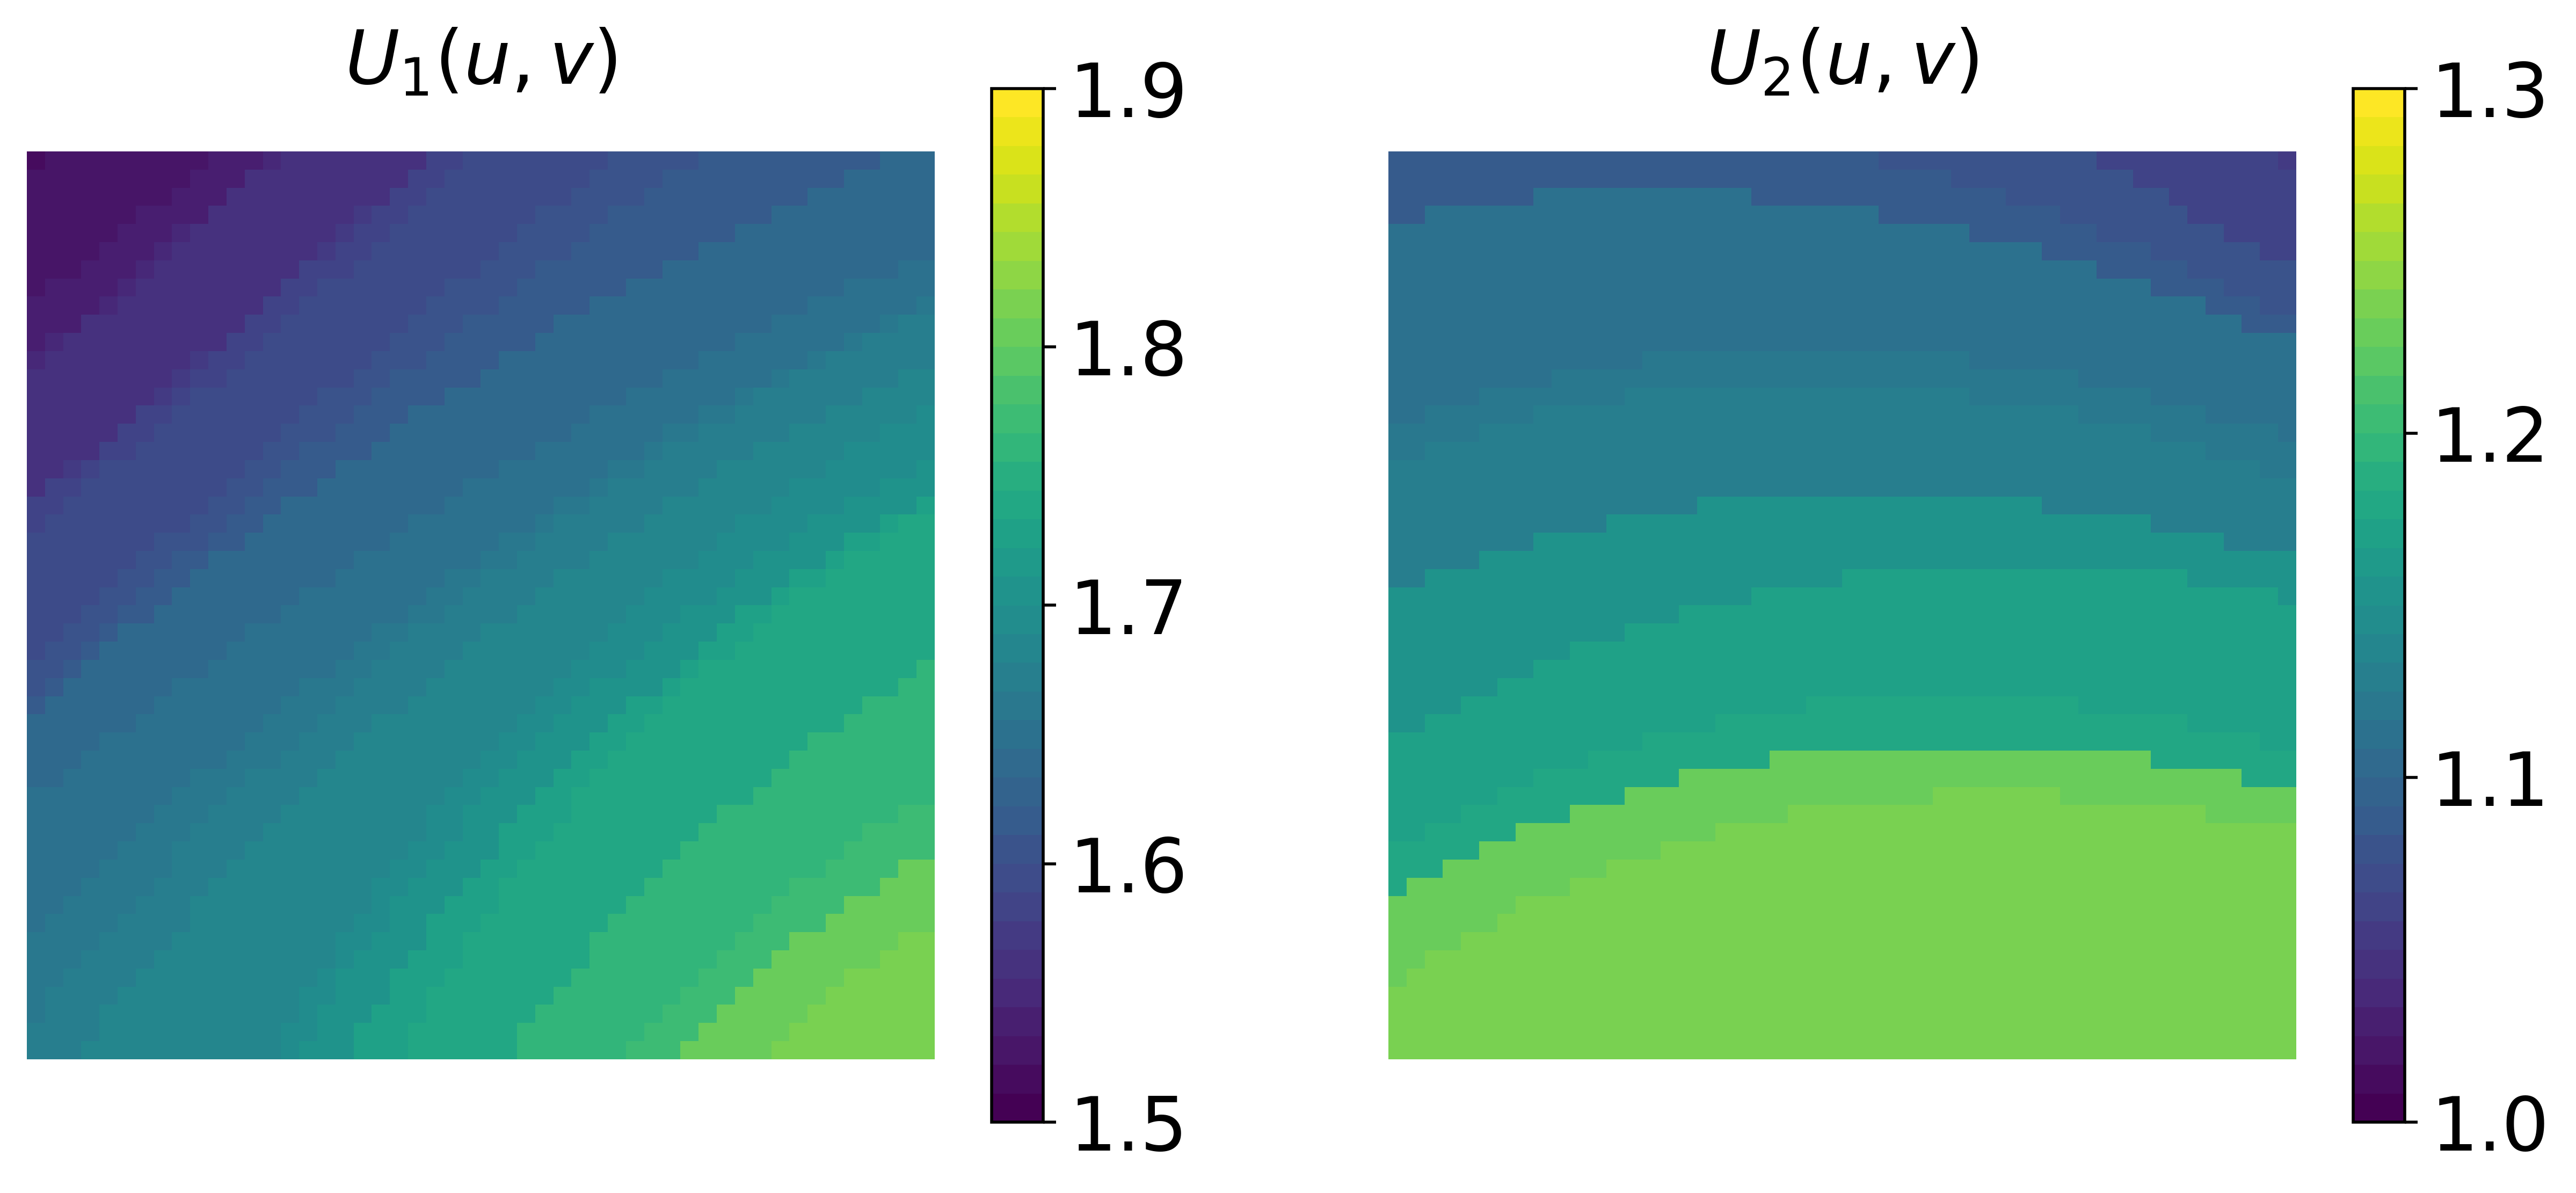

In [51]:
plot_s(geo_uncertainty_list, k=2, sub_titles=sub_titles_uncertainty, title='UncertaintyOfCoef - ConformalSHAPSmoothed + Noise',
       non_spatial=[], size=size)

In [52]:
X1_uncertainty_shap = pred_results[['X1_geo_uncertainty', 'X1_shap_abs', 'x', 'y']]
X1_uncertainty_shap.columns = ['geo_uncertainty', 'shap_abs', 'x', 'y']

In [53]:
X2_uncertainty_shap = pred_results[['X2_geo_uncertainty', 'X2_shap_abs', 'x', 'y']]
X2_uncertainty_shap.columns = ['geo_uncertainty', 'shap_abs', 'x', 'y']

In [54]:
uncertainty_list = [X1_uncertainty_shap, X2_uncertainty_shap]

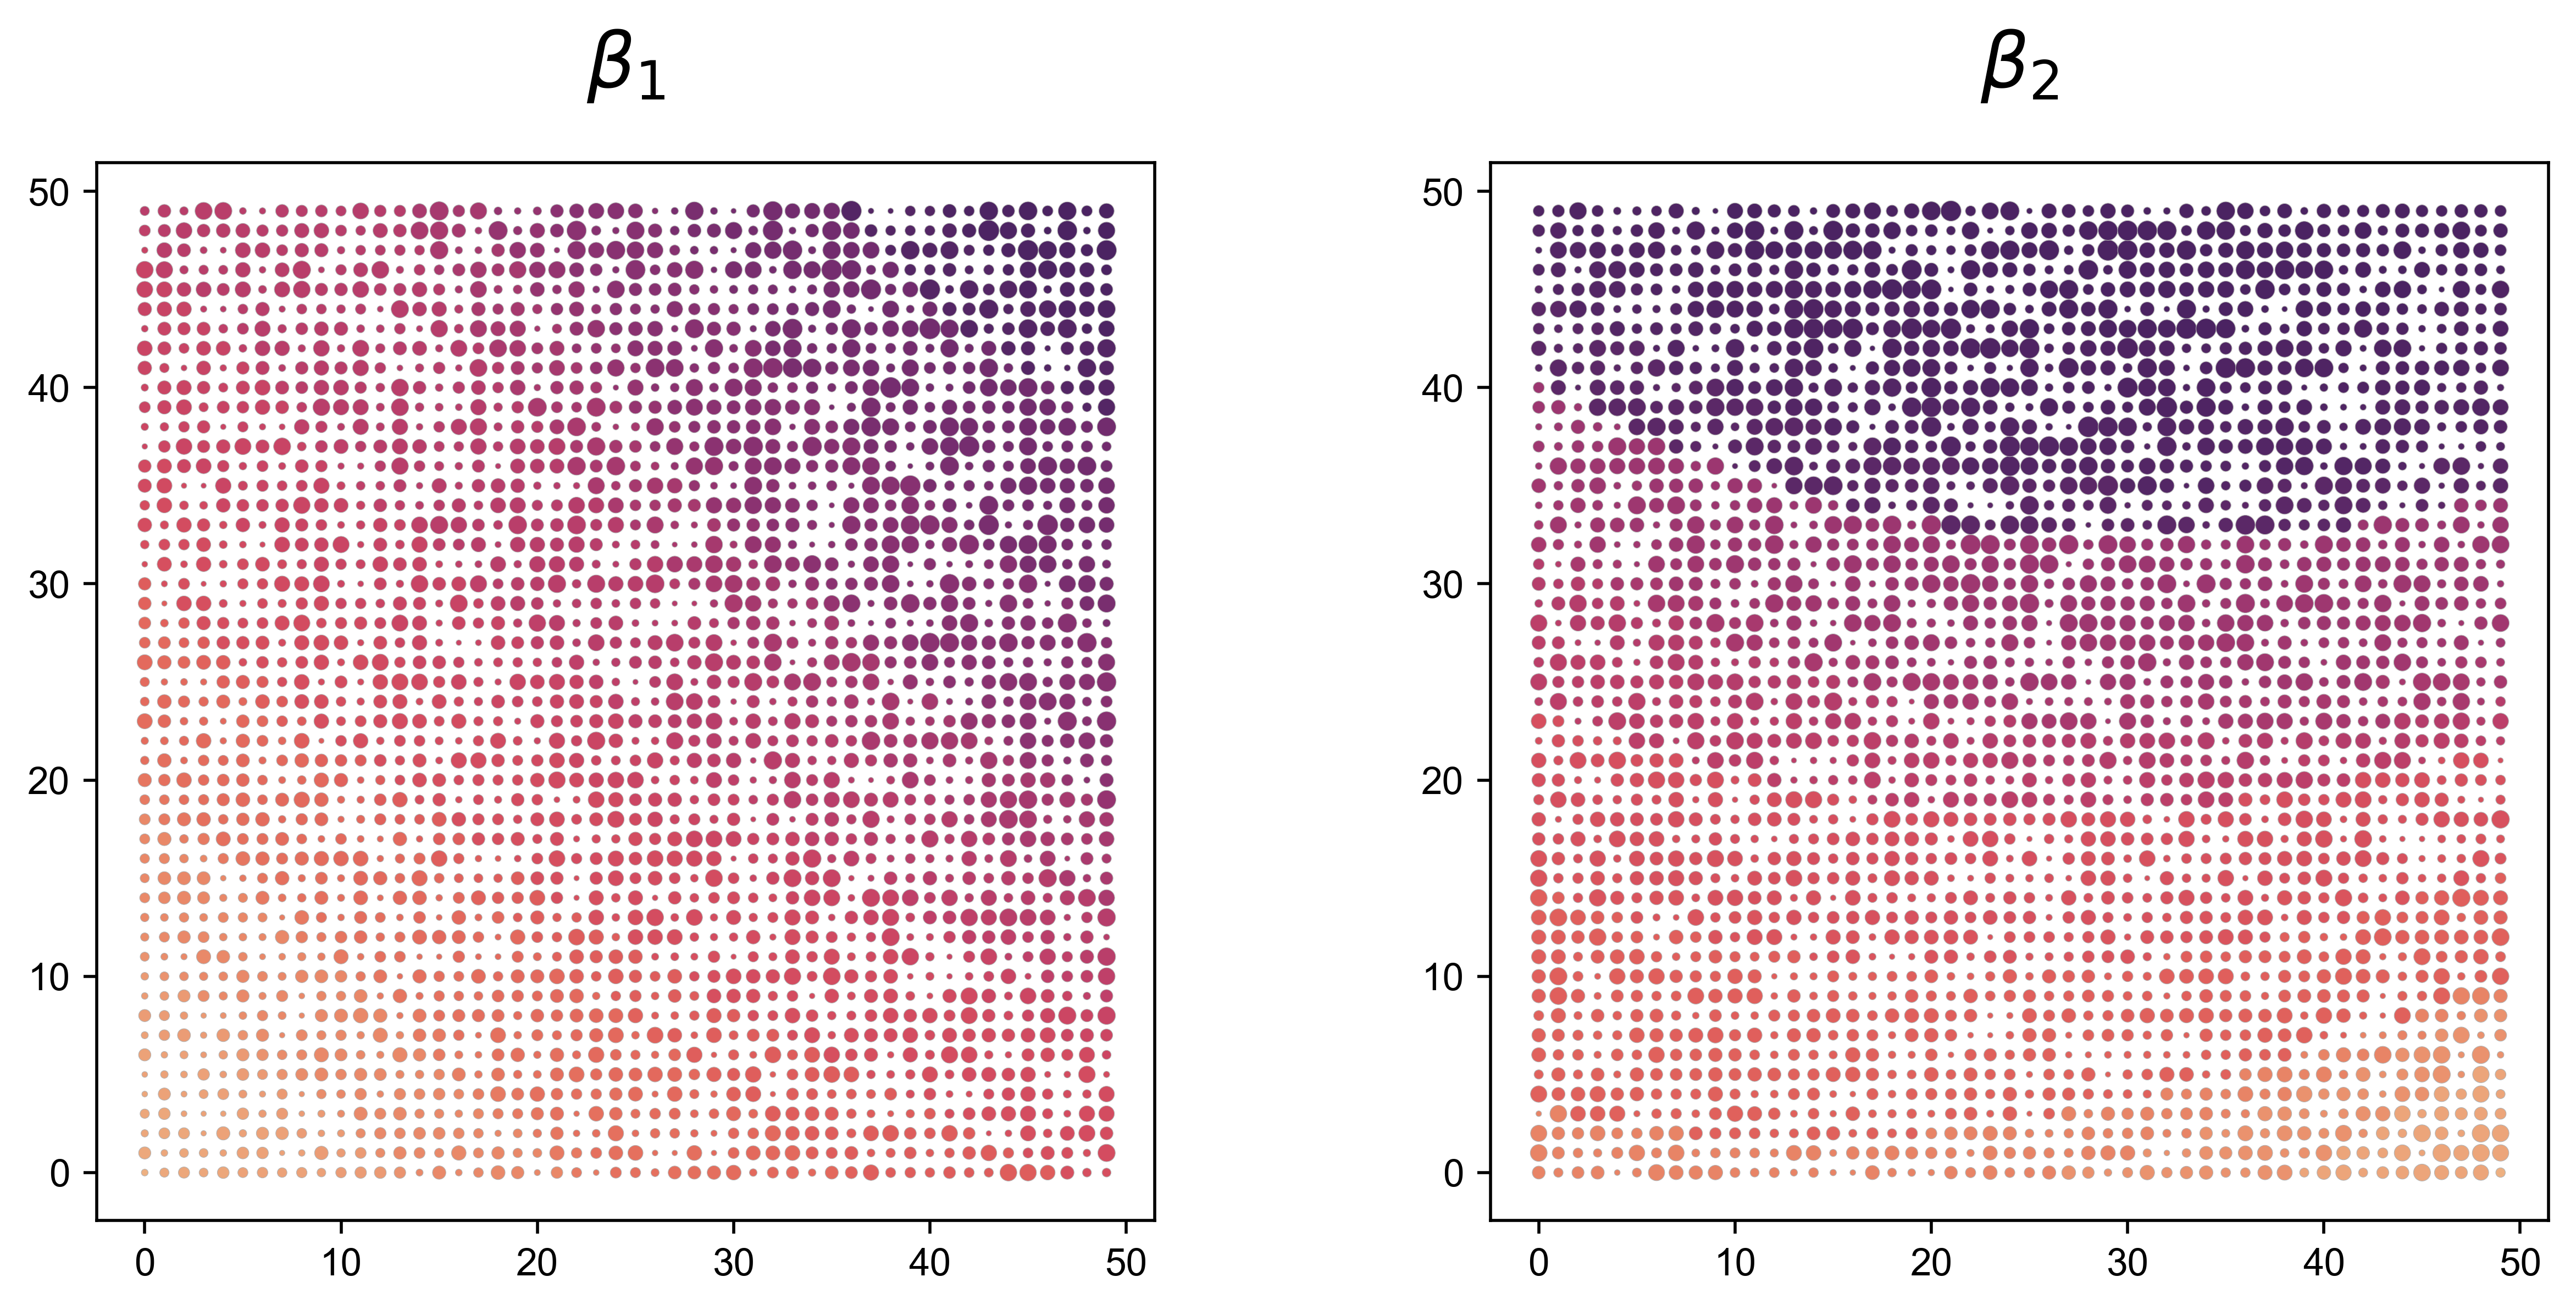

In [55]:
plot_uncertainty(uncertainty_list, k=2, sub_titles=[r'$\beta_1$', r'$\beta_2$'], s_limits=(2, 30),
                 title='Synthetic Data -Uncertainty - ExactSHAP + Noise')